In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import metrics
from xgboost import XGBClassifier
from source.utils import MetricsSaver, saveConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from scipy.fft import fft


sys.path.append('/home/texs/Documentos/Repositories/ts2vec')
from ts2vec import TS2Vec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
datasetName = 'PAMAP2' # PAMAP2 or HAR-UML20
FEATURE_SIZE = 32
# CLASS_LABELS = ['Sedentary', 'Light', 'Moderate', 'Vigorous']
UMAP_NEIGHTBORS = 15
N_EPOCHS = 2000
RESULTS_PATH = 'results'

In [11]:


if datasetName == 'PAMAP2':
    dataset = DatasetPAMAP2(mode = 'leave-one-subject', signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3'])
    
elif datasetName ==  'HAR-UML20':
    dataset = DatasetHARUML20(mode = 'leave-one-subject')
    
CLASS_LABELS = [
    "Sedentary",
    "Light",
    "Moderate",
    "Vigorous",
]

saver = MetricsSaver(datasetName + '_PAI_TS2VEC', rows = ['train', 'test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])

In [12]:
predicted_classes = []
real_classes = []
while dataset.loadData():
    # if datasetName == 'PAMAP2':
    #     le = LabelEncoder()
    #     dataset.y_train = le.fit_transform(dataset.Int_train)
    #     dataset.y_test = le.transform(dataset.Int_test)
    
    # Preparing data
    ts_train = TSerie(dataset.X_train[:, :, :6], dataset.Int_train)
    ts_test = TSerie(dataset.X_test[:, :, :6], dataset.Int_test)
    minv, maxv = ts_train.minMaxNormalization()
    ts_test.minMaxNormalization(minl=minv, maxl=maxv)
    
    model = TS2Vec(
        input_dims=6,
        device=0,
        output_dims=64,
        batch_size=64,
    )
    
    # ts_train.features =  np.linalg.norm(ts_train.X[:, :, :3], axis=2)
    # ts_test.features = np.linalg.norm(ts_test.X[:, :, :3], axis=2)
    
    # for i in range(ts_train.N):
    #     ts_train.features[i] = np.absolute(fft(ts_train.features[i]))
        
    # for i in range(ts_test.N):
    #     ts_test.features[i] = np.absolute(fft(ts_test.features[i]))
    
    # ts_train.folding_features_v2()
    # ts_test.folding_features_v2()
    
    model.fit(ts_train.X, verbose=True,n_epochs = 6)
    ts_train.features =  model.encode(ts_train.X, encoding_window='full_series')
    ts_test.features =  model.encode(ts_test.X, encoding_window='full_series')
    
    # Getting features
    # model = UMAP_FL(n_components=FEATURE_SIZE,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS)
    # ts_train.features = model.fit_transform(ts_train.features, y=ts_train.y)
    # ts_test.features = model.transform(ts_test.features)
    
    
    # Classifying
    clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    clf.fit(ts_train.features, ts_train.y)
    train_pr = clf.predict(ts_train.features)
    test_pr = clf.predict(ts_test.features)
    predicted_classes.append(test_pr)
    real_classes.append(ts_test.y)


    # Save metrics
    train_f1 = metrics.f1_score(ts_train.y, train_pr, average='weighted')
    test_f1 = metrics.f1_score(ts_test.y, test_pr, average='weighted')
    train_bacc = metrics.balanced_accuracy_score(ts_train.y, train_pr)
    test_bacc = metrics.balanced_accuracy_score(ts_test.y, test_pr)
    train_acc = metrics.accuracy_score(ts_train.y, train_pr)
    test_acc = metrics.accuracy_score(ts_test.y, test_pr)
    
    saver.addLog('train', 'F1-score', train_f1)
    saver.addLog('test', 'F1-score', test_f1)
    saver.addLog('train', 'Balanced Accuracy', train_bacc)
    saver.addLog('test', 'Balanced Accuracy', test_bacc)
    saver.addLog('train', 'Accuracy', train_acc)
    saver.addLog('test', 'Accuracy', test_acc)
    
predicted_classes = np.concatenate(predicted_classes, axis = 0)
real_classes = np.concatenate(real_classes, axis = 0)

Epoch #0: loss=3.9605036228895187
Epoch #1: loss=3.863821583489577
Epoch #2: loss=3.4876308689514794
Epoch #3: loss=3.115293058256308
Epoch #4: loss=2.413026121755441
Epoch #5: loss=2.003497747083505
Epoch #0: loss=3.9755757306751454
Epoch #1: loss=3.862064080489309
Epoch #2: loss=3.6077382037514134
Epoch #3: loss=2.7724282201967743
Epoch #4: loss=2.2680574191244025
Epoch #5: loss=1.9881319497760974
Epoch #0: loss=3.916946204341188
Epoch #1: loss=3.869357452100637
Epoch #2: loss=3.4393271718706404
Epoch #3: loss=2.5133681978498186
Epoch #4: loss=2.11437375448188
Epoch #5: loss=1.9014319546368657


/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch #0: loss=3.9387150605519614
Epoch #1: loss=3.883817804356416
Epoch #2: loss=3.4816641559203467
Epoch #3: loss=2.612503112604221
Epoch #4: loss=2.0535735872884593
Epoch #5: loss=1.8905491828918457
Epoch #0: loss=3.990871244861234
Epoch #1: loss=3.930861706374794
Epoch #2: loss=3.8217818198665494
Epoch #3: loss=3.3456007434475805
Epoch #4: loss=2.658075996624526
Epoch #5: loss=2.2460631106489446
Epoch #0: loss=3.9334054196134525
Epoch #1: loss=3.8049595558896976
Epoch #2: loss=3.6435865366712528
Epoch #3: loss=2.5747051175604474
Epoch #4: loss=2.1955165926446307
Epoch #5: loss=1.8374208731854216
Epoch #0: loss=3.959954209076731
Epoch #1: loss=3.918934746792442
Epoch #2: loss=3.857362870166176
Epoch #3: loss=3.7256585924248946
Epoch #4: loss=3.6328907113326223
Epoch #5: loss=2.8109837707720304
Epoch #0: loss=3.9580365270376205
Epoch #1: loss=3.608678941925367
Epoch #2: loss=2.6498505448301635
Epoch #3: loss=2.1037716567516327
Epoch #4: loss=1.9035237270096939
Epoch #5: loss=1.708715

/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [13]:
# if datasetName == 'PAMAP2':
#     classes = np.unique(real_classes)
#     CLASS_LABELS = [dataset.activities_map[classL] for classL in le.inverse_transform(classes) ]

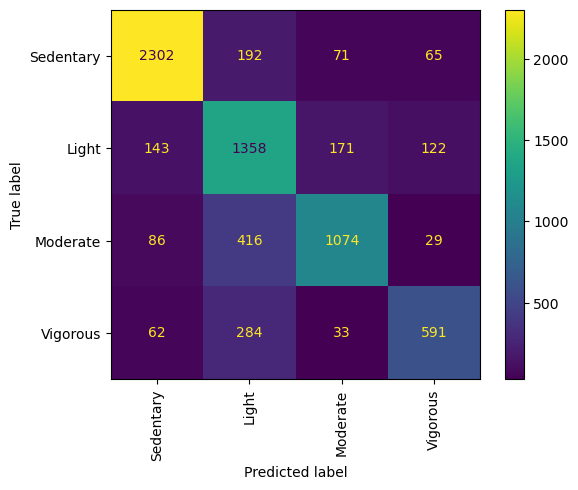

In [14]:

saveConfusionMatrix(real_classes, predicted_classes, datasetName + '_PAI_TS2VEC', labels=CLASS_LABELS, xrotation=90)

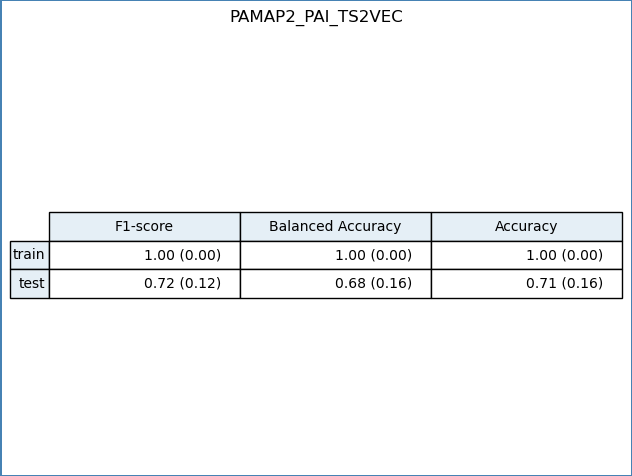

In [15]:
saver.toImage()